<h1 style="color:green; font-family:Georgia">
Machine Learning for KAGGLE Handwritten letter recognition ::
</h1>

<span style = "font-family:Geogia; color:orange; font-size:14px">
<h5 style="color:red; font-family:Georgia; text-decoration: underline">About Dataset :<h5>
Context: Consist 28$\times$28 handwritten Alphabet images <br>

<h5 style="color:red; font-family:Georgia; text-decoration: underline">Content</h5>
There are total 785 columns, each row consists an image of alphabets. The first coloumn represents the alphabet numbering from 0-25 as A-Z.<br>
data URL: https://www.kaggle.com/datasets/ashishguptajiit/handwritten-az/data
<hr>
</span>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 22 22:18:32 2024
@author: mrsag
"""

"""
Importing modules
"""

import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from Curve_fitting_with_scipy import Linefitting as Lf
from scipy.signal import fftconvolve
from collections import defaultdict
import PIL
from scipy.ndimage import rotate, zoom
from scipy import ndimage
import math
from skimage import io, draw
import joblib
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier,ExtraTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor, StackingClassifier, StackingRegressor
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, KNeighborsTransformer, RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, PassiveAggressiveRegressor
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, RidgeCV, Ridge, SGDClassifier, SGDRegressor, SGDOneClassSVM, TweedieRegressor
from sklearn.linear_model import ARDRegression, QuantileRegressor, HuberRegressor, RANSACRegressor, TheilSenRegressor, GammaRegressor, PoissonRegressor
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier, XGBRFRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor



import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi'] = 120  # highres display

In [2]:
def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index


def moving_average(signal, window_size):
    # Define the window coefficients for the moving average
    window = np.ones(window_size) / float(window_size)
    
    # Apply the moving average filter using fftconvolve
    filtered_signal = fftconvolve(signal, window, mode='same')
    
    return filtered_signal


def hist_dataframe(df, bins=10):
    # Define a list of colors for each histogram
    colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'purple', 'orange', 'black']
    # Create subplots with a dynamic number of rows, 3 columns per row
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / 3)), ncols=3, figsize=(18, 4.5*int(np.ceil(len(df.columns) / 3))))
    # Flatten the axes array for easy iteration (even if it's a 2D grid)
    axes = axes.flatten()
    
    # Plot each histogram individually
    for i, column in enumerate(df.columns):
        df[column].plot(kind='hist', ax=axes[i], color=colors[i%len(colors)], title=column, bins = bins)
        axes[i].grid(True, linewidth=0.5, color='k')  # Optional: add grid
    
    # Turn off any unused subplots (in case the number of columns is not a multiple of 3)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])  # Delete empty subplots
    
    plt.tight_layout()  # Adjust the layout
    plt.show()
    pass
    

def binned_mode(data, num_bins):     
    """ use this function to replace the missing value with the most probable value in a dataset...
        There are inbuilt functions for mean and median"""
    # Calculate the range of the data
    data_min, data_max = min(data), max(data)
    
    # Calculate the bin edges
    bins = np.linspace(data_min, data_max, num_bins + 1)
    
    # Group data into bins
    binned_data = defaultdict(list)
    for num in data:
        # Find the correct bin index for each number
        bin_index = np.digitize(num, bins) - 1  # subtract 1 to get 0-based index
        bin_index = min(bin_index, num_bins - 1)  # ensure last bin is included
        binned_data[bin_index].append(num)
    
    # Find the bin with the highest frequency
    most_frequent_bin = max(binned_data, key=lambda k: len(binned_data[k]))
    
    # Calculate the average of the values in the most frequent bin
    mode_value = np.mean(binned_data[most_frequent_bin])
    
    return mode_value


def plot_hollow_pillar_histogram(data, bins=30, edgecolor='black', linewidth=1.5):   #, xlabel='Value', ylabel='Frequency', title='Histogram with Hollow Pillar Bars'):
    """
    Plots a histogram with hollow pillar bars.

    Parameters:
    - data: Array of data to be plotted.
    - bins: Number of bins or bin edges (default is 30).
    - edgecolor: Color of the bar edges (default is 'black').
    - linewidth: Thickness of the bar edges (default is 1.5).
    - xlabel: Label for the x-axis (default is 'Value').
    - ylabel: Label for the y-axis (default is 'Frequency').
    - title: Title for the plot (default is 'Histogram with Hollow Pillar Bars').
    """
    # Create the histogram without plotting it (retrieve the counts and bin edges)
    counts, bin_edges = np.histogram(data, bins=bins)
    # Width of each bar
    bin_width = bin_edges[1] - bin_edges[0]
    # Create the plot
    for i in range(bins):
        plt.hist(bin_edges[i]*np.ones(counts[i]),bins=1, edgecolor='black', linewidth=0.5, rwidth=(max(data)-min(data))/bins)
        
    # Set limits for x and y axis
    # ax.set_xlim(bin_edges[0], bin_edges[-1])
    # ax.set_ylim(0, max(counts) * 1.1)
    # Add labels and title
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    # plt.title(title)
    pass



def get_numerical_categorical_boolean_columns(data):
    # Separate categorical and numerical columns
    categorical_columns = []
    numerical_columns = []
    boolean_columns = []
    
    for name in np.array(data.columns):
        i=0
        while(data[name][i] is None):
            i += 1

        if(type(data[name][i]) is str):
            categorical_columns.append(name)
        elif((type(data[name][i]) is float) or (type(data[name][i]) is int) or (type(data[name][i]) is bin) or (type(data[name][i]) is np.int64) 
            or (type(data[name][i]) is np.int32) or (type(data[name][i]) is np.int16) or (type(data[name][i]) is np.int8) or 
            (type(data[name][i]) is np.float16) or (type(data[name][i]) is np.float32) or (type(data[name][i]) is np.float64)):
            
            numerical_columns.append(name)
        elif((type(data[name][i]) is bool)):
             boolean_columns.append(name)
        else:
            pass
    return numerical_columns, categorical_columns, boolean_columns

@np.vectorize
def n_th_alphabet(n):
    if 0 <= n <= 25:
        return chr(65 + n)
    else:
        return "Input out of range. Please provide a number between 0 and 25."


In [3]:
import pandas as pd

file_path = "D:\\ML Dataset\\Kaggle handwritten alphabet a-z\\handwritten_data_785.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(data.shape)
print(data.info())

(372037, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372037 entries, 0 to 372036
Columns: 785 entries, 0 to 0.571
dtypes: int64(785)
memory usage: 2.2 GB
None


<span style = "font-family:Geogia; color:orange; font-size:14px">
First we need the shuffle the data and then separate the features and labels.<br>
The first column is label and all other columns are features...
</span>

In [4]:
shuffled_index = np.random.permutation(data.shape[0])
data = data.iloc[shuffled_index]
data_reduced = data.iloc[:100000]
x = data_reduced.drop("0",axis=1)
y = data_reduced["0"]

print(x.shape)
print(y.shape)

(100000, 784)
(100000,)


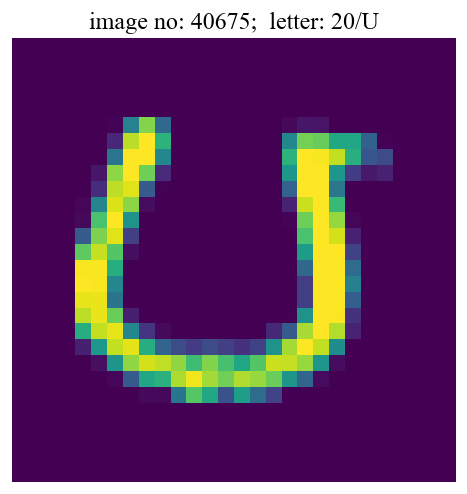

In [5]:
" Showing a random image "
index = np.random.randint(0, x.shape[0])
random_image = np.array((x.iloc[index])).reshape(28,28)
# print(random_image)
plt.imshow(random_image)
plt.axis("off")
plt.title(f"image no: {index};  letter: {y.iloc[index]}/{n_th_alphabet(y.iloc[index])}")
plt.show()

In [6]:
train_percent = int(len(y)*0.8)

x_train, y_train = np.array(x[:train_percent]), np.array(y[:train_percent])
x_test, y_test = np.array(x[train_percent:]), np.array(y[train_percent:])

y_train, y_test = y_train.astype(np.int8), y_test.astype(np.int8)

print(f"Train data size: {x_train.shape}\nTest data size: {x_test.shape}")

Train data size: (80000, 784)
Test data size: (20000, 784)


In [7]:
# model = LogisticRegression()
model = RandomForestClassifier()
# model = DecisionTreeClassifier()
# model = KNeighborsClassifier()
# model = ExtraTreesClassifier()

model.fit(x_train, y_train)
# cross_val_scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=10)

y_predict = model.predict(x_test)
print(f"accuracy_score: {accuracy_score(y_test, y_predict)*100} %")

accuracy_score: 94.91000000000001 %


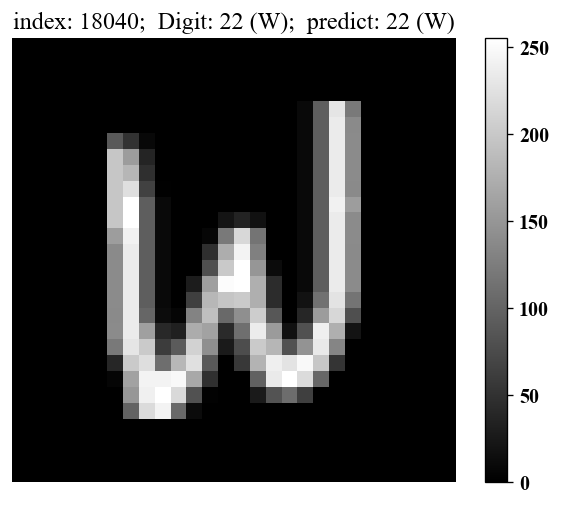

In [14]:
index = np.random.randint(len(y_test)-1)

random_image = np.array((x_test[index])).reshape(28,28)
# print(random_image)
plt.imshow(random_image, cmap='gray')
plt.colorbar()
plt.axis("off")
plt.title(f"index: {index};  Digit: {y_test[index]} ({n_th_alphabet(y_test[index])});  predict: {y_predict[index]} ({n_th_alphabet(y_predict[index])})")
plt.show()

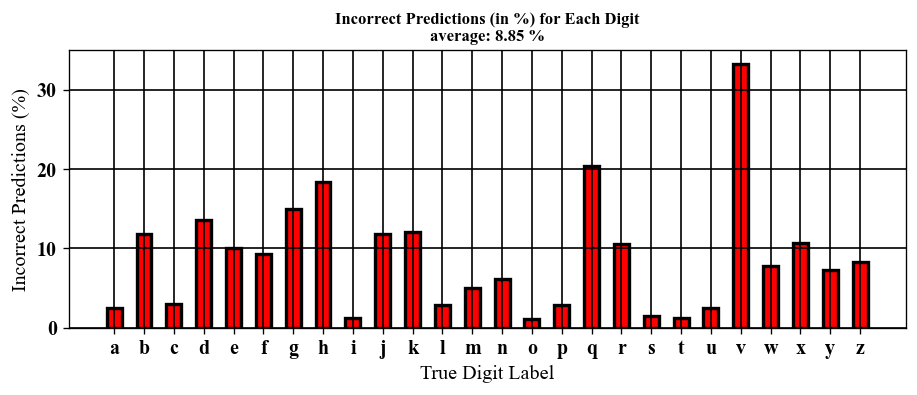

In [15]:
# Identify incorrect predictions
incorrect_indices = np.where(y_test != y_predict)[0]
incorrect_labels = y_test[incorrect_indices]# Extract the corresponding true labels (y_test) for incorrect predictions
total_per_digit = np.bincount(sorted(y_test), minlength=10) # Calculate the total occurrences of each digit in the test set
incorrect_per_digit = np.bincount(sorted(incorrect_labels), minlength=10)  # Calculate the incorrect occurrences for each digit
percentage_incorrect_per_digit = (incorrect_per_digit / total_per_digit) * 100  # Calculate the percentage of incorrect predictions for each digit

import string
# Plot the percentage of incorrect predictions for each digit
plt.figure(figsize=(9,3))
plt.bar(np.arange(len(set(y_test))), percentage_incorrect_per_digit, color='red', edgecolor='black', linewidth = 2, width=0.5)
labels = dict(zip(range(0, 26), string.ascii_lowercase))
plt.xticks(ticks=list(labels.keys()), labels=list(labels.values()))  # Digits 0 to 9
plt.xlabel('True Digit Label')
plt.ylabel('Incorrect Predictions (%)')
plt.title('Incorrect Predictions (in %) for Each Digit\n'+f"average: {np.mean(percentage_incorrect_per_digit):.2f} %", fontsize=10, fontweight='bold')
plt.grid(True, lw=1, color = 'k')
plt.show()